In [70]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import CondensedNearestNeighbour

# Sklearn ML
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [71]:
# Initialize variables to control pipeline
normalize_bool = 0
outlier_bool = 0
resample_bool = 0
feature_selection = 0
dim_reduction_bool = 0

# Initialize variable for first test/train split
test_percent = 0.15

# Use same random seed to ensure same results across runs
rand_seed = 100

In [72]:
# Load the data
filepath = "data/train.csv"
class_df = pd.read_csv(
    filepath, usecols=[1, 2], header=0, names=["uid", "class"]
)

display(class_df)

,uid,class
0,ZYURRE527,4
1,ZWNWBP435,0
2,ZVHEZA963,4
3,ZSFNU1100,4
4,ZRXUB1049,0
...,...,...
422,AGHXWX765,0
423,AFEOPC672,3
424,AEEEIG737,3
425,ADQRPH513,3


In [73]:
# Load features from individual CSVs into a single dataframe
def get_features(uid):
    feature_filepath = f"data/img_details/{uid}.csv"
    feature_df = pd.read_csv(feature_filepath, header=None)
    return feature_df.iloc[0].values.tolist()


features_df = class_df[["uid"]].apply(
    lambda row: get_features(row[0]), axis=1, result_type="expand"
)
display(features_df)


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.000462,0.005583,-0.001031,0.002307,-0.113097,-0.284965,0.001069,-0.000092,-0.271864,0.000503,...,0.680631,-1.153061,0.111816,0.162622,-1.085265,-0.657002,-1.406191,2.240085,0.118616,-0.728013
1,0.000220,0.006780,-0.000547,0.002183,-0.045820,-0.216762,0.000987,-0.001331,-0.465898,0.000515,...,-1.241972,-0.115316,-0.411191,0.431461,0.442649,1.243681,-0.151721,0.458508,1.931918,-0.241081
2,0.000405,0.007183,-0.000137,0.002612,-0.083430,-0.292385,0.001094,-0.000112,-0.236576,0.000466,...,0.659314,-0.792833,-0.471358,0.514799,-0.846220,0.479314,-0.730218,1.352716,0.040223,-0.163302
3,0.000388,0.003802,0.002121,0.001513,-0.109248,-0.183284,0.000813,-0.001447,-0.066267,0.000654,...,-0.047666,-0.201043,-0.565545,0.999009,-0.332314,-0.066972,-1.263785,3.876905,-0.397950,-0.693763
4,0.000425,0.006544,0.001630,0.001549,-0.068301,-0.283487,0.001004,-0.001800,-0.251112,0.000428,...,-1.221178,-0.253239,-0.046740,0.242367,-0.379724,-0.893249,-0.957397,1.118245,0.181925,-0.024197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,0.000305,0.003671,-0.004093,0.003010,-0.093583,0.133018,0.000627,0.001443,-0.367352,0.000462,...,-0.260746,-0.741712,-0.887129,0.190525,0.216271,0.490549,-1.047399,1.875185,0.345561,-0.874318
423,0.000441,0.006178,-0.000811,0.003572,-0.108863,-0.302020,0.000761,0.001851,-0.197981,0.000310,...,0.457373,-0.782917,-1.072765,1.180279,-0.111142,1.897755,-0.902370,0.552967,-0.314270,-1.198762
424,0.000464,0.006611,0.000842,0.001412,-0.152744,-0.355706,0.000906,-0.001229,-0.320724,0.000493,...,0.411773,0.232481,-0.527885,-0.305296,-0.189008,-0.592684,-1.144780,3.459698,-0.199579,-0.999165
425,0.000233,0.003029,0.001606,0.001224,-0.092386,-0.434045,0.000668,-0.000410,-0.228858,0.000444,...,-0.147889,1.168724,-0.486698,1.134707,-0.029372,0.092189,-0.791921,1.786787,2.089036,-0.690614


In [74]:
# Merge dataframes and fix column names
num_features = features_df.shape[1]
feature_names = [f"f{i}" for i in range(num_features)]

features_df.columns = feature_names

df = pd.concat([class_df, features_df], axis=1)
display(df)

,uid,class,f0,f1,f2,f3,f4,f5,f6,f7,...,f1014,f1015,f1016,f1017,f1018,f1019,f1020,f1021,f1022,f1023
0,ZYURRE527,4,0.000462,0.005583,-0.001031,0.002307,-0.113097,-0.284965,0.001069,-0.000092,...,0.680631,-1.153061,0.111816,0.162622,-1.085265,-0.657002,-1.406191,2.240085,0.118616,-0.728013
1,ZWNWBP435,0,0.000220,0.006780,-0.000547,0.002183,-0.045820,-0.216762,0.000987,-0.001331,...,-1.241972,-0.115316,-0.411191,0.431461,0.442649,1.243681,-0.151721,0.458508,1.931918,-0.241081
2,ZVHEZA963,4,0.000405,0.007183,-0.000137,0.002612,-0.083430,-0.292385,0.001094,-0.000112,...,0.659314,-0.792833,-0.471358,0.514799,-0.846220,0.479314,-0.730218,1.352716,0.040223,-0.163302
3,ZSFNU1100,4,0.000388,0.003802,0.002121,0.001513,-0.109248,-0.183284,0.000813,-0.001447,...,-0.047666,-0.201043,-0.565545,0.999009,-0.332314,-0.066972,-1.263785,3.876905,-0.397950,-0.693763
4,ZRXUB1049,0,0.000425,0.006544,0.001630,0.001549,-0.068301,-0.283487,0.001004,-0.001800,...,-1.221178,-0.253239,-0.046740,0.242367,-0.379724,-0.893249,-0.957397,1.118245,0.181925,-0.024197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,AGHXWX765,0,0.000305,0.003671,-0.004093,0.003010,-0.093583,0.133018,0.000627,0.001443,...,-0.260746,-0.741712,-0.887129,0.190525,0.216271,0.490549,-1.047399,1.875185,0.345561,-0.874318
423,AFEOPC672,3,0.000441,0.006178,-0.000811,0.003572,-0.108863,-0.302020,0.000761,0.001851,...,0.457373,-0.782917,-1.072765,1.180279,-0.111142,1.897755,-0.902370,0.552967,-0.314270,-1.198762
424,AEEEIG737,3,0.000464,0.006611,0.000842,0.001412,-0.152744,-0.355706,0.000906,-0.001229,...,0.411773,0.232481,-0.527885,-0.305296,-0.189008,-0.592684,-1.144780,3.459698,-0.199579,-0.999165
425,ADQRPH513,3,0.000233,0.003029,0.001606,0.001224,-0.092386,-0.434045,0.000668,-0.000410,...,-0.147889,1.168724,-0.486698,1.134707,-0.029372,0.092189,-0.791921,1.786787,2.089036,-0.690614


In [75]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_all = df[feature_names]
y_all = df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=test_percent, random_state=rand_seed, stratify=y_all
)

# Reset X_train index
y_train.reset_index(inplace=True, drop=True)
X_train.reset_index(inplace=True, drop=True)

print("Training set by class:")
display(y_train.value_counts())
print("Test set by class:")
display(y_test.value_counts())

Training set by class:


0    135
4     92
3     66
1     46
2     23
Name: class, dtype: int64

Test set by class:


0    24
4    17
3    12
1     8
2     4
Name: class, dtype: int64

### Normalizing Data

Use StandardScaler from sklearn.

In [67]:
# Create function that will normalize the X_train data
def norm_data(X_train):
    # Setup scaler
    scaler_std = StandardScaler()
    #scaler_abs = MaxAbsScaler()
    #scaler_minmax = MinMaxScaler()
    
    # Apply scaling to training data
    X_train = scaler_std.fit_transform(X_train)
    
    return X_train

In [68]:
# Test norm_data function
X_train = norm_data(X_train)

# Check mean and std after normalization
norm_mean = np.mean(X_train)
norm_std = np.std(X_train)
norm_var = np.var(X_train)

print(norm_mean)
print(norm_std)
print(norm_var)

0.43659260889260926
0.20171072818755917
0.040687217865955375


### Remove Outliers

Standard deviation approach - For each class, features with values more than +/- 3 standard deviations away from the per class per feature mean will be removed.

Since we are in multi-dimensional space, we will use the mean and covariance matrices. This will be computed using Mahalanobis distance which is well-suited for multi-dimensional space: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.mahalanobis.html.

In [68]:
# Create function that computes mean, cov matrix, and inv cov matrix
def get_mean_cov(X_train):
    # Merge dfs
    norm_x_df = pd.DataFrame(X_train, columns=feature_names)
    norm_df = pd.concat([y_train, norm_x_df], axis=1)

    # Compute mean and cov per class per feature
    avg_list = []
    cov_list = []
    inv_cov_list = []
    for i in range(5):
        # Compute mean
        avg = np.mean(norm_df[norm_df["class"]==i][feature_names], axis=0)
        avg_list.append(avg)
        # Compute cov matrix
        cov = np.cov(norm_df[norm_df["class"]==i][feature_names], rowvar=False)
        cov_list.append(cov)
        # Compute inverse of cov matrix
        inv_cov = np.linalg.inv(cov)
        inv_cov_list.append(inv_cov)
    return norm_df, avg_list, inv_cov_list

    #display(avg_list)

In [69]:
# Test get_mean_cov function
norm_df, avg_list, inv_cov_list = get_mean_cov(X_train)

In [70]:
# Determine which features should be removed (identify outliers based on Mahalanobis dist)
# Create function that computes Mahalanobis distance and adds it to norm_df
def get_mahalanobis_dist(label, features):
    u = avg_list[label]
    v = features
    vi = inv_cov_list[label]
    delta = u - v
    m = np.dot(np.dot(delta, vi), delta)
    #dist = distance.mahalanobis(u, features, vi)
    return np.sqrt(np.abs(m))

# Call function for each feature
norm_df["mahalanobis_dist"] = norm_df.apply(lambda row: get_mahalanobis_dist(int(row["class"]), row[feature_names]), axis=1)
norm_df["mahalanobis_dist"].describe()

# Initialize list for distances
# dist = np.zeros(norm_df.shape[0])
# for i, row in norm_df.iterrows():
#     dist[i] = get_mahalanobis_dist(int(row["class"]), row[feature_names])

count    362.000000
mean      42.746361
std       28.969791
min        1.314860
25%       20.756832
50%       35.317028
75%       56.876198
max      143.976839
Name: mahalanobis_dist, dtype: float64

Distances seem high, but we may have a lot of outliers! Plus there are so many features that the sum becomes large. The distance was calculated for all 362 image feature vectors in the training dataset, so we can move on to the next step.

In [71]:
# Drop outliers
def drop_outliers(norm_df, threshold):
    thresh = threshold
    norm_df.sort_values(by="mahalanobis_dist", ascending=False, inplace=True)
    norm_df.reset_index(inplace=True, drop=True)
    norm_df.drop(norm_df.index[:int(norm_df.shape[0]*thresh)], inplace=True)
    norm_df.reset_index(inplace=True, drop=True)

    return norm_df

In [72]:
# Test drop_outliers function
norm_df = drop_outliers(norm_df, 0.2)

# Print updated descriptive stats
norm_df["mahalanobis_dist"].describe()
#print(len(norm_df["class"]))

count    290.000000
mean      30.784539
std       15.618092
min        1.314860
25%       18.561889
50%       27.950168
75%       41.555643
max       66.632329
Name: mahalanobis_dist, dtype: float64

In [73]:
# Get class counts after dropping outliers
#print(norm_df["class"].value_counts())

### Addressing Class Imbalance

In [74]:
# Create function that oversamples or undersamples data
def resample(sampler, X_train, y_train, name):
    X_train, y_train = sampler.fit_resample(X_train, y_train)
    # Observe number of classes after resample
    #print(f"Number of samples per class after {name}:\n{y_train.value_counts()}")
    return X_train, y_train

In [75]:
# Test resample function
# Setup ADASYN (oversampling)
ada = ADASYN(random_state=rand_seed)
# Setup random undersampling
undersample = RandomUnderSampler()

# Call resample function
#X_train, y_train = resample(undersample, X_train, y_train, "Random Undersampling")

### Reduce Dimensionality - Linear Discriminant Analysis

In [76]:
# Linear Discriminant Analysis to reduce dimensionality of problem
def use_lda(X_train, y_train):
    lda_clf = LinearDiscriminantAnalysis()
    lda_model = lda_clf.fit(X_train, y_train)
    X_lda = lda_model.transform(X_train)
    return X_lda, lda_model

In [77]:
# Test use_lda function
#X_lda, lda_model = use_lda(X_train, y_train)

In [78]:
# Plot LDA results
def plot_lda(X_lda, y_train):
    # Visualize LDA results
    target_class = np.unique(y_train)
    colors = ["red", "green", "blue", "black", "brown"]
    # Get number of components
    n_components = X_lda.shape[1]
    pairs = []
    for xi in range(n_components):
        for yi in range(n_components):
            if yi > xi:
                pairs.append((xi,yi))

    # Setup subplots
    fig, ax = plt.subplots(len(pairs), 1, figsize=(10,30))

    # Get every combination of LDA components
    # Setting up all values to plot
    for ax_i,(xi,yi) in enumerate(pairs):
        # Plot data
        for color, i, c in zip(colors, [0,1,2,3,4], target_class):
            ax[ax_i].scatter(X_lda[y_train == i, xi],
                X_lda[y_train == i, yi],
                alpha=.8, color=color, label=c)
        # Add legend
        ax[ax_i].set_xlabel(f"Component {xi}")
        ax[ax_i].set_ylabel(f"Component {yi}")
        ax[ax_i].legend(loc="best")

    # Set title on the plot
    #plt.title("Linear Discriminant Analysis")
    plt.tight_layout()

In [79]:
# Test plot_lda function
#plot_lda(X_lda, y_train)

### Reduce Dimensionality - PCA

In [32]:
# Principal Component Analysis to reduce dimensionality of problem
def use_pca(X_train, y_train):
    pca_clf = PCA()
    pca_model = pca_clf.fit(X_train, y_train)
    X_pca = pca_model.transform(X_train)
    return X_pca, pca_model

## Training SVM Classifier with Transformed Data

In [558]:
# Create pipeline
# PIPELINE 1: NORMALIZE, DROP OUTLIERS, UNDERSAMPLE, LDA
# Normalize
X_train = norm_data(X_train)
normalize_bool = 1

# Drop outliers
norm_df, avg_list, inv_cov_list = get_mean_cov(X_train)
norm_df["mahalanobis_dist"] = norm_df.apply(lambda row: get_mahalanobis_dist(int(row["class"]), row[feature_names]), axis=1)
outlier_thresh = 0.2
norm_df = drop_outliers(norm_df, outlier_thresh)
outlier_bool = 1

# Resample
undersample = RandomUnderSampler()
X_train = norm_df[feature_names]
y_train = norm_df["class"]
X_train, y_train = resample(undersample, X_train, y_train, "Random Undersampling")
resample_bool = 1

# LDA
X_lda, lda_model = use_lda(X_train, y_train)
dim_reduction_bool = 1

In [615]:
# PIPELINE 2: NORMALIZE, DROP OUTLIERS, LDA
# Normalize
X_train = norm_data(X_train)
normalize_bool = 1

# Drop outliers
norm_df, avg_list, inv_cov_list = get_mean_cov(X_train)
norm_df["mahalanobis_dist"] = norm_df.apply(lambda row: get_mahalanobis_dist(int(row["class"]), row[feature_names]), axis=1)
outlier_thresh = 0.2
norm_df = drop_outliers(norm_df, outlier_thresh)
outlier_bool = 1

# LDA
X_lda, lda_model = use_lda(X_train, y_train)
dim_reduction_bool = 1

In [640]:
# PIPELINE 3: NORMALIZE, DROP OUTLIERS
# Normalize
X_train = norm_data(X_train)
normalize_bool = 1

# Drop outliers
norm_df, avg_list, inv_cov_list = get_mean_cov(X_train)
norm_df["mahalanobis_dist"] = norm_df.apply(lambda row: get_mahalanobis_dist(int(row["class"]), row[feature_names]), axis=1)
outlier_thresh = 0.2
norm_df = drop_outliers(norm_df, outlier_thresh)
outlier_bool = 1

In [80]:
# PIPELINE 4: NORMALIZE, DROP OUTLIERS, PCA
# # Normalize
# X_train = norm_data(X_train)
# normalize_bool = 1

# # Drop outliers
# norm_df, avg_list, inv_cov_list = get_mean_cov(X_train)
# norm_df["mahalanobis_dist"] = norm_df.apply(lambda row: get_mahalanobis_dist(int(row["class"]), row[feature_names]), axis=1)
# outlier_thresh = 0.2
# norm_df = drop_outliers(norm_df, outlier_thresh)
# outlier_bool = 1

# PCA
X_pca, pca_model = use_pca(X_train, y_train)
dim_reduction_bool=1

In [616]:
# Run LDA on X test data to match dimensionality of train data
#X_test_lda = lda_model.transform(X_test)

c:\Users\heath\anaconda3\envs\pattern-classification\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(


In [81]:
# Run PCA on X test data to match dimensionality of train data
X_test_pca = pca_model.transform(X_test)

In [69]:
# Use components to train SVM classifier
svm_clf = SVC(kernel="rbf", random_state=10)
svm_model = svm_clf.fit(X_train, y_train)

# Use cross_validate from sklearn to obtain accuracies for 5-fold cross validation
#cv_results = cross_validate(svm_clf, X_train, y_train, cv=5,
#    scoring='accuracy')

# Print accuracy for each fold
#for i in range(0,5):
#    print(f"The accuracy for fold {i} is: {cv_results['test_score'][i]:.3f}")
    
y_pred = svm_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")

print(f"Accuracy: {acc:.3f}")
print(f"F1 score: {f1:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

Accuracy: 0.369
F1 score: 0.199
Precision: 0.136
Recall: 0.369


c:\Users\heath\anaconda3\envs\pattern-classification\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\Users\heath\anaconda3\envs\pattern-classification\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


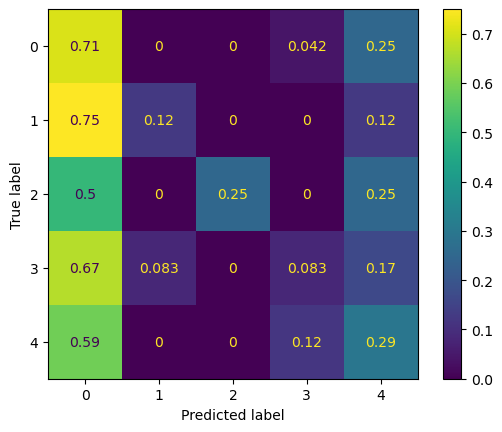

In [83]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize="true")

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [84]:
# Save all results to a DataFrame
# First, initialize dataframe
pipeline_results_df = pd.DataFrame(columns=["F1Score", "Accuracy", "Precision", "Recall",
    "TestSplit", "KFold", "Normalized", "OutlierRemoval", "OutlierThreshold",
    "Resample", "ReduceDimension"])

pipeline_results_df.loc[0] = [f1, acc, precision, recall, test_percent, 0, normalize_bool,
    outlier_bool, outlier_thresh, resample_bool, dim_reduction_bool]  

print(pipeline_results_df)

    F1Score  Accuracy  Precision    Recall  TestSplit  KFold  Normalized  \
0  0.341409  0.384615   0.402385  0.384615       0.15    0.0         0.0   

   OutlierRemoval  OutlierThreshold  Resample  ReduceDimension  
0             0.0               0.2       0.0              1.0  


In [85]:
# Save results to csv
# Check if csv exists
file_path = "outputs/pipeline_results.csv"
if os.path.isfile(file_path):
    # Append new results
    pipeline_results_df.to_csv(file_path, mode="a", header=False)
else:
    # Create new csv and add results
    pipeline_results_df.to_csv(file_path, header=True)
